In [1]:
portfolio_sd_t <- function(sd, cov, weight){
  stopifnot(length(sd) > 1, is.matrix(cov), length(sd) == length(weight))
  for(i in 1:(length(sd)-1)){
    for(j in (i+1):length(sd)){
      n <- sum(weight[i:length(sd)]^2*sd[i:length(sd)]^2)
      m <- sum(2*weight[i]*weight[j]*cov[i,j])
      sd <- sqrt(sum(weight[i:length(sd)]^2*sd[i:length(sd)]^2+
                       2*weight[i]*weight[j]*cov[i,j]))
      return(sd)
    }
  }
}
portfolio_return <- function(returns, weight){
  if(!is.vector(returns) > 1){
    mean <- apply(returns,2,mean, na.rm = T)
  } else{
    if(is.vector(returns)){
      mean <- returns
    }
  }
  total_return <- sum(weight*mean)
  return(total_return)
}

In [2]:
options(warn = -1, verbose = F)
suppressPackageStartupMessages({
    library(dplyr)
    library(tidyr)
    library(ggplot2)
    library(tidyquant)
    library(pracma)
})

In [3]:
#Estipule os parâmetros para calcular os desvios-padrão e os retornos médios (diários e anuais)
acoes <- c("OIBR3.SA","JHSF3.SA","MEAL3.SA","SMLS3.SA","BRSR6.SA","ELET3.SA","BBAS3.SA",
          "LOGN3.SA","VALE3.SA")
retornos_d <- tq_get(acoes, from = Sys.Date()-365) %>%
  group_by(symbol) %>%
  tq_transmute(select = close, mutate_fun= periodReturn, period = "daily")
retornos_a <- tq_get(acoes, from = Sys.Date()-365*5) %>%
  group_by(symbol) %>%
  tq_transmute(select = close, mutate_fun= periodReturn, period = "yearly", fill = 0) %>%
  mutate(year = year(date)) %>%
  group_by(year,symbol) %>%
  summarise(yearly.returns) %>%
  spread(key = "symbol", value = "yearly.returns") %>%
  na.fill(fill = 0)
sd_d <- retornos_d %>%
  group_by(symbol) %>%
  summarise(sd = sd(daily.returns)) %>%
  spread(key = "symbol", value = sd)
cov <- retornos_d %>%
  spread(key = "symbol", value = daily.returns)
cov$date <- NULL
cov <- cov(cov)

`summarise()` regrouping output by 'year' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



In [4]:
#Nº de simulações de carteiras a se fazer
n_sim <- 50000
pesos <- matrix(0,length(acoes),n_sim)
pesos <- apply(pesos,2,rnorm)
for(i in 1:ncol(pesos)){
  pesos[,i] <- pesos[,i]/sum(pesos[,i])
  if(any(pesos[,i] < -1| pesos[,i] > 1)){
    pesos[,i] <- 0
  }
}
col_sub <- apply(pesos,2,function(col)all(col != 0))
pesos <- pesos[,col_sub]

In [5]:
ncol(pesos)

[1] 28096

In [6]:
time <- system.time({
    riscos <- apply(pesos, 2, portfolio_sd_t, sd = sd_d, cov = cov)*sqrt(252)
    retornos <- apply(pesos, 2, portfolio_return, returns = retornos_a[,2:ncol(retornos_a)])
})
time

   user  system elapsed 
 233.93    0.82  257.54 

In [7]:
#Sharpe
tx_livre_risco <- 0.0225
data <- data.frame(riscos = riscos, retornos = retornos, sharpe = (retornos-tx_livre_risco)/riscos)
data <- na.omit(data)

In [8]:
#Retorno médio das ações
retorno_med <- retornos_a %>%
  data.frame %>%
  gather(key = "symbol", value = "return", -year) %>%
  group_by(symbol) %>%
  summarise(media = mean(return)) %>%
  spread(key = "symbol", value = "media")

`summarise()` ungrouping output (override with `.groups` argument)



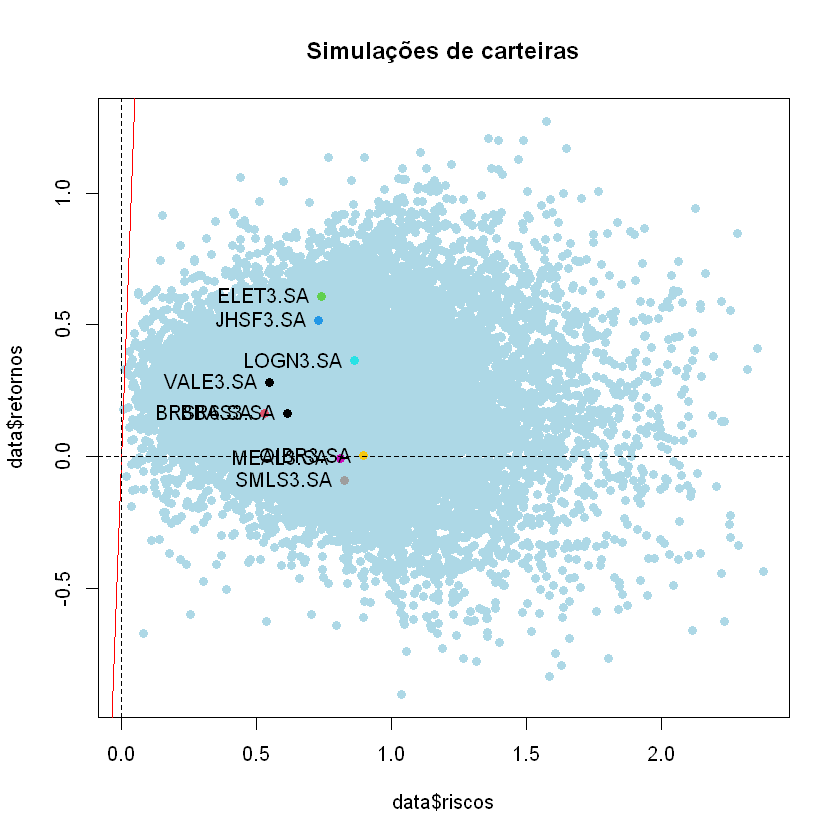

In [9]:
plot(data$riscos, data$retornos, pch = 16, col = "lightblue",
     xlim = c(min(data$riscos),max(data$riscos)),
    ylim = c(min(data$retornos), max(data$retornos)), main = "Simulações de carteiras")
points(x = sd_d*sqrt(252), y = retorno_med, col = 1:ncol(retorno_med), pch = 16)
text(x = sd_d*sqrt(252), y = retorno_med, labels = colnames(retorno_med), pos = 2)
abline(a = tx_livre_risco, b = max(data$sharpe), col = "red")
abline(h = 0, v = 0, lty  = 2)

In [10]:
sharpe <- max(data$sharpe)
names(sharpe) <- "Sharpe Máximo"
Ret_max <- max(data$retornos)
names(Ret_max) <- "Retorno Máximo"
sd_min <- min(data$riscos)
names(sd_min) <- "Risco Mínimo"
sharpe
Ret_max
sd_min

Sharpe Máximo 
     27.25359

Retorno Máximo 
       1.27252

Risco Mínimo 
 0.008615546

## Para encontrar os pesos de carteira de maior sharpe é necessário colar o maior sharpe no ctr+f, ver a linha em que está e dar print na coluna de mesmo número da matriz "pesos"

In [14]:
show(data)

           riscos       retornos         sharpe
1     0.469748645  0.23047809856  0.44274337097
2     0.301396163  0.16617689265  0.47670445202
3     0.527331167  0.31832443001  0.56098415675
4     0.893246774  0.45921058624  0.48890250588
5     0.395366852  0.13720341801  0.29011895550
6     1.845030213  0.15525243687  0.07195136205
7     1.248520911 -0.40558640972 -0.34287484183
8     0.111354391  0.03143653146  0.08025306746
10    0.556196417  0.25026293299  0.40950089935
12    0.714396598  0.49662529852  0.66367239129
13    0.390666648  0.14067532208  0.30249657270
14    0.534266529  0.05972516594  0.06967527237
15    0.770682679  0.22424010145  0.26176804920
16    1.118326731 -0.11566201614 -0.12354351581
18    0.574481471  0.53522136374  0.89249417003
20    0.604121989  0.42460939274  0.66560959605
21    0.840852339  0.30619479987  0.33738955919
22    0.431266115  0.37268507878  0.81199302853
23    0.560054371  0.47330279589  0.80492684193
24    0.490351973 -0.03491486607 -0.1170

In [140]:
pesos[,5269]

[1]  0.96627899 -0.36238806  0.60861958 -0.29436174  0.01334995 -0.30142098
[7]  0.36992226

In [141]:
#Os pesos acima equivalem as ações em ordem alfabética
sort(acoes)

[1] "ITSA4.SA" "MDIA3.SA" "MGLU3.SA" "OIBR3.SA" "PETR4.SA" "TRPL4.SA" "VVAR3.SA"